# LICK Template
This template should work for 3D spherical and 2D (r-theta) simulations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lick.lick import lick_box

Update the following block with your data format
Here using a IDEFIX dataset and nonos to load it

In [2]:
##################### IDEFIX #####################
from nonos.styling import set_mpl_style
set_mpl_style(1.0)
from nonos.api import GasDataSet

ds = GasDataSet(100, directory=".")
redge, tedge = (ds.coords.get_axis_array(_c) for _c in ["r","theta"])
rmed, tmed = (ds.coords.get_axis_array_med(_c) for _c in ["r","theta"])
rho, stream1, stream2 = (ds[_field].data for _field in ["RHO","VX1","VX2"])
##################### IDEFIX #####################

/home/gwf/projects/lick_template/.venv/lib/python3.13/site-packages/nonos/_readers/binary.py:349: RuntimeWarning: invalid value encountered in divide
  zcart[0, :, 0]


Convert coordinates from spherical to cartesian

In [3]:
rrmed, ttmed = np.meshgrid(rmed, tmed, indexing="ij")
xxmed = rrmed*np.sin(ttmed)
zzmed = rrmed*np.cos(ttmed)
tmed3d = tmed[None,:]

Perform azimuthal average of the 3 fields

In [4]:
rhodata = np.mean(rho, axis=2)
vector_r = np.mean(stream1, axis=2)
vector_theta = np.mean(stream2, axis=2)

Convert the data (velocity/magnetic field lines) from spherical to cartesian

In [5]:
vector_R = vector_r*np.sin(tmed3d) + vector_theta*np.cos(tmed3d)
vector_z = vector_r*np.cos(tmed3d) - vector_theta*np.sin(tmed3d)

OPTIONAL: define a window for the lick to focus on that window
remove these everywhere if you want the lic on the whole data

In [6]:
xmin_window = 0.0
xmax_window = redge.max()#1.6
ymin_window = -redge.max()#-0.5
ymax_window = redge.max()#0.5

Perform the lic in cartesian (xxmed, zzmed) for the 3 fields
zooming on the specified window. In particular: 
- 'size_interpolated': the minimal number of cells in one direction, 
keeping the aspect ratio
- 'method': 'linear' interpolation to compute the streamlines, can be quicker with 'nearest'
- 'niter_lic': number of iterations for the lic algorithm, 6 is the default value,
too high values can create artefacts

In [7]:
# size_interpolated=1000
# niter_lic=6
# kernel_length=101
size_interpolated=99
niter_lic=1
kernel_length=2

Xi, Yi, v1i, v2i, fieldi, licv = lick_box(
    xxmed,
    zzmed,
    vector_R,
    vector_z,
    rhodata,
    xmin=xmin_window,
    xmax=xmax_window,
    ymin=ymin_window,
    ymax=ymax_window,    
    size_interpolated=size_interpolated,
    method="nearest",
    niter_lic=niter_lic,
    kernel_length=kernel_length,
)

Add a mask inside rmin/tmin and outside rmax/tmax

In [8]:
D = np.sqrt(Xi**2+Yi**2)
A = np.arctan(Yi/Xi)+np.pi/2
Dmin = redge.min()
Dmax = redge.max()
Amin = tedge.min()
Amax = tedge.max()
mask = ((D<Dmin)|(D>Dmax)|(A<Amin)|(A>Amax))
fieldi = np.ma.masked_where(mask, fieldi)
licv = np.ma.masked_where(mask, licv)
v1i = np.ma.masked_where(mask, v1i)
v2i = np.ma.masked_where(mask, v2i)

/tmp/ipykernel_284220/1016131869.py:2: RuntimeWarning: divide by zero encountered in divide
  A = np.arctan(Yi/Xi)+np.pi/2


Plotting section

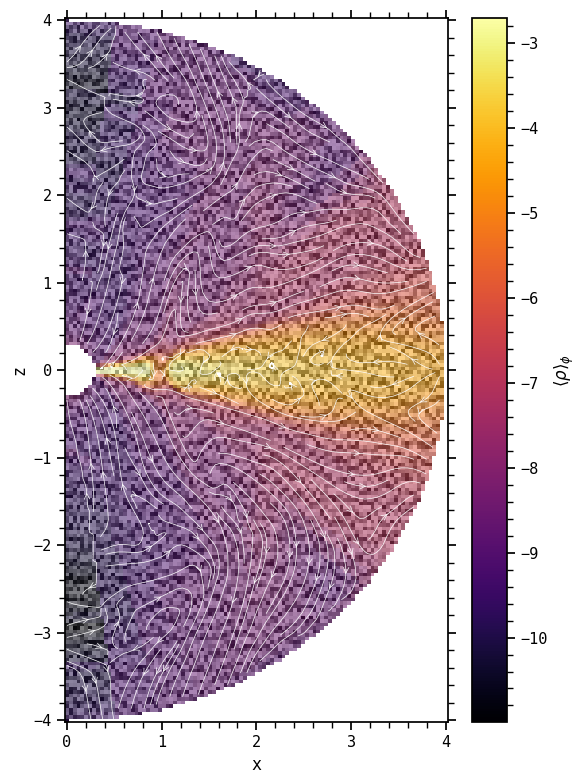

In [9]:
plt.close("all")
fig, ax = plt.subplots(figsize=(6,8))
vmin, vmax = (None,None)
cmap = "inferno"

"""
plot the background field (e.g. the density), here in log
"""
im = ax.pcolormesh(
    Xi, 
    Yi, 
    np.log10(fieldi), 
    vmin=vmin, 
    vmax=vmax, 
    cmap=cmap, 
    shading="nearest", 
    # rasterized=True
)
cbar = fig.colorbar(im)
cbar.set_label(r"$\langle \rho \rangle_\phi$")

"""
plot the lic with a level of transparency,
you can play with alpha to enhance/diminish the lic
"""
ax.pcolormesh(
    Xi, 
    Yi, 
    licv, 
    alpha=0.5, 
    cmap="binary_r", 
    shading="nearest", 
    # rasterized=True
)

"""
to add some streamlines, controled in particular with 'density'
"""
ax.streamplot(
    Xi,
    Yi,
    v1i,
    v2i,
    density=2,
    arrowstyle="->",
    linewidth=0.5,
    color="w",
)

ax.set(aspect="auto", xlabel="x", ylabel="z")
fig.tight_layout()